In [44]:
# !pip install requests
# !pip install beautifulsoup4
# !pip install wikipedia
# !pip install pandas
# !pip install wptools

In [45]:
import os
import requests
from bs4 import BeautifulSoup
import wikipedia
import pandas as pd
import wptools
import json

def fetch_nobel_laureates(url, category='not set'):
  response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
  soup = BeautifulSoup(response.content, 'html.parser')

  # Find the table containing the data
  tables = soup.find_all('table', {'class': 'wikitable'})

  nobel_laureates_df = pd.read_html(str(tables))
  nobel_laureates_df = nobel_laureates_df[0]
  nobel_laureates_df.columns = nobel_laureates_df.columns.str.lower() # Lowercase column names
  nobel_laureates_df = nobel_laureates_df.drop(columns=['image', 'rationale[c]', 'ref'])
  nobel_laureates_df = nobel_laureates_df.rename(columns={'laureate[a]': 'name', 'country[b]': 'country'})
  nobel_laureates_df['name'] = nobel_laureates_df['name'].str.replace(r'\s*\([^()]*\)', '', regex=True)
  # Drop duplicate name rows
  nobel_laureates_df = nobel_laureates_df.drop_duplicates(subset=['name'], keep='first')
  # Drop rows with missing values in the name column (e.g. empty rows)
  nobel_laureates_df = nobel_laureates_df.dropna(subset=['name'])
  # Drop rows with text containing 'Not awarded' in the name column
  nobel_laureates_df = nobel_laureates_df[~nobel_laureates_df['name'].str.contains('Not awarded', case=False)]
  nobel_laureates_df = nobel_laureates_df[~nobel_laureates_df['name'].str.contains('Skłodowska', case=False)]

  # Add a column for the category
  nobel_laureates_df['category'] = category
  return nobel_laureates_df.head(100)


In [46]:
# Create function to fetch biography of laureates from Wikipedia
def fetch_biography(name):
  search = wikipedia.search(name)[0]
  try:
    page = wikipedia.page(search)
    full_content = page.content # we are getting all the content of the page for now
  except:
    # suggestions
    wp_page = wptools.page(name)
    query = wp_page.get_query()
    page_id = query.data["pageid"]
    page = wikipedia.page(pageid=page_id)
    full_content = page.content
  return full_content

In [47]:
def fetch_rdf_triples(name):
    # Replace spaces with underscores
    name = name.replace(" ", "_")
    query = f"""
    SELECT DISTINCT ?subject ?predicate ?object
    WHERE {{
        ?subject dbo:wikiPageWikiLink dbr:{name} .
        ?subject ?predicate ?object .
    }}
    LIMIT 100
    """




    url = "https://dbpedia.org/sparql"
    headers = {
        "Accept": "application/sparql-results+json"
    }
    params = {
        "query": query,
        "format": "json"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        return response.json()['results']['bindings']
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

In [48]:
# if the data directory does not exist, create it
if not os.path.exists('physics_nobel_laureate'):
    os.makedirs('physics_nobel_laureate')

if not os.path.exists('chemistry_nobel_laureate'):
    os.makedirs('chemistry_nobel_laureate')

physics_nobel_laureate = fetch_nobel_laureates('https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Physics', 'Physics')

# Apply the fetch_biography function to the name column of the DataFrame
physics_nobel_laureate['biography'] = physics_nobel_laureate['name'].apply(fetch_biography)


# Save each laureate's data to a /data/name_physics_nobel_laureate.txt file
for index, row in physics_nobel_laureate.iterrows():
    name = row['name']
    row_string = '\n'.join([f'{key}: {value}' for key, value in row.items()])
    # Save the data to a file
    with open(f'physics_nobel_laureate/{name.replace(" ", "")}_.txt', 'w', encoding="utf-8") as f:
        f.write(row_string)
    rdf_triples = fetch_rdf_triples(name) # Fetch RDF triples
    # Save the RDF triples to a json file
    with open(f'physics_nobel_laureate/{name.replace(" ", "")}.json', 'w', encoding="utf-8") as f:
        json.dump(rdf_triples, f)

# print(len(physics_nobel_laureate))
# print(physics_nobel_laureate.head(10))

C:\Users\alber\AppData\Local\Temp\ipykernel_4680\2796701783.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  nobel_laureates_df = pd.read_html(str(tables))
Marie Curie (en) data
{
  WARNINGS: <dict(2)> main, extracts
  aliases: <list(4)> Maria Salomea Skłodowska, Maria Skłodowska-Cu...
  assessments: <dict(10)> Medicine, Military history, Biography, P...
  description: Polish and French physicist and chemist (1867–1934)
  extext: <str(2778)> **Maria Salomea Skłodowska-Curie** (Polish: ...
  extract: <str(3406)> <p class="mw-empty-elt"></p><p><b>Maria Sal...
  image: <list(4)> {'kind': 'query-pageimage', 'file': 'File:Marie...
  label: Marie Curie
  length: 109,318
  links: <list(828)> 1903 Nobel Memorial Prize in Economic Science...
  modified: <dict(1)> page
  pageid: 20408
  random: Thunder Brigade
  redirects: <list(34)> {'pageid': 20409, 'ns': 0, 'title':

In [49]:
chemistry_nobel_laureate = fetch_nobel_laureates('https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Chemistry', 'Chemistry')

# Apply the fetch_biography function to the name column of the DataFrame
chemistry_nobel_laureate['biography'] = chemistry_nobel_laureate['name'].apply(fetch_biography)

# Save each laureate's data to a /data/name_chemistry_nobel_laureate.txt file
for index, row in chemistry_nobel_laureate.iterrows():
    name = row['name']



    row_string = '\n'.join([f'{key}: {value}' for key, value in row.items()])
    # Save the data to a file
    with open(f'chemistry_nobel_laureate/{name.replace(" ", "")}.txt', 'w', encoding="utf-8") as f:
        f.write(row_string)
    rdf_triples = fetch_rdf_triples(name) # Fetch RDF triples
    # Save the RDF triples to a json file
    with open(f'chemistry_nobel_laureate/{name.replace(" ", "")}.json', 'w', encoding="utf-8") as f:
        json.dump(rdf_triples, f)

# print(len(chemistry_nobel_laureate))
# print(chemistry_nobel_laureate.head(20))

C:\Users\alber\AppData\Local\Temp\ipykernel_4680\2796701783.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  nobel_laureates_df = pd.read_html(str(tables))
William Ramsay (en) data
{
  WARNINGS: <dict(2)> main, extracts
  aliases: <list(1)> Sir William Ramsay
  assessments: <dict(3)> Biography, Scotland, Chemistry
  description: Scottish chemist
  extext: <str(600)> **Sir William Ramsay** (; 2 October 1852 – 23...
  extract: <str(660)> <p class="mw-empty-elt"></p><p><b>Sir Willia...
  image: <list(2)> {'kind': 'query-pageimage', 'file': 'File:Willi...
  label: William Ramsay
  length: 17,024
  links: <list(299)> 1902 Coronation Honours, 1904 Nobel Memorial ...
  modified: <dict(1)> page
  pageid: 48187
  random: Dignity of Labour
  redirected: <list(1)> {'from': 'Sir William Ramsay', 'to': 'Will...
  redirects: <list(3)> {'pageid': 98014, 'ns': 0, 'title': 'S

In [50]:
physics_and_chemistry_nobel_laureate = pd.concat([physics_nobel_laureate, chemistry_nobel_laureate], axis=0)

In [51]:
physics_and_chemistry_nobel_laureate

,year,name,country,category,biography
0,1901,Wilhelm Röntgen,German Empire,Physics,Wilhelm Conrad Röntgen (; German pronunciation...
1,1902,Hendrik Lorentz,Netherlands,Physics,Hendrik Antoon Lorentz (; 18 July 1853 – 4 Feb...
2,1902,Pieter Zeeman,Netherlands,Physics,Pieter Zeeman (Dutch: [ˈzeːmɑn]; 25 May 1865 –...
3,1903,Henri Becquerel,France,Physics,Antoine Henri Becquerel (; French pronunciatio...
4,1903,Pierre Curie,France,Physics,"Pierre Curie ( KURE-ee, French: [pjɛʁ kyʁi]; 1..."
...,...,...,...,...,...
105,1981,Roald Hoffmann,United States Poland,Chemistry,"Roald Hoffmann (born Roald Safran; July 18, 19..."
106,1982,Aaron Klug,United Kingdom,Chemistry,Sir Aaron Klug (11 August 1926 – 20 November ...
107,1983,Henry Taube,United States,Chemistry,"Henry Taube, (November 30, 1915 – November 16..."
108,1984,Robert Bruce Merrifield,United States,Chemistry,"Robert Bruce Merrifield (July 15, 1921 – May 1..."


In [9]:
physics_and_chemistry_nobel_laureate.to_csv("physics_and_chemistry_nobel_laureate.csv", index=False)

### Word Cloud

In [12]:
# This should be shared between each text exercise
# Apply the operations to the clean_biography column
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

def clean_text_spacy(text):
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(words)

# Apply the clean_text_spacy function to the biography column
physics_and_chemistry_nobel_laureate['clean_biography'] = physics_and_chemistry_nobel_laureate['biography'].apply(clean_text_spacy)

print(physics_and_chemistry_nobel_laureate['clean_biography'])



0      Wilhelm Conrad Röntgen german pronunciation ˈv...
1      Hendrik Antoon Lorentz July February dutch phy...
2      Pieter Zeeman Dutch ˈzeːmɑn October dutch phys...
3      Antoine Henri Becquerel french pronunciation b...
4      Pierre Curie KURE ee French pjɛʁ kyʁi April fr...
                             ...                        
105    Roald Hoffmann bear Roald Safran July polish a...
106    Sir Aaron Klug August November british biophys...
107    Henry Taube November November Canadian bear am...
108    Robert Bruce Merrifield July american biochemi...
109    Herbert Aaron Hauptman February October americ...
Name: clean_biography, Length: 200, dtype: object


Word Dictionary:  {'University': 1044, 'work': 897, 'Physics': 739, 'Nobel': 688, 'theory': 607, 'year': 549, 'Prize': 525, 'Einstein': 472, 'physics': 460, 'Institute': 420, 'research': 403, 'physicist': 392, 'time': 377, 'Bohr': 375, 'later': 360, 'quantum': 360, 'paper': 350, 'Feynman': 343, 'study': 339, 'receive': 332, 'award': 325, 'Academy': 319, 'know': 318, 'particle': 317, 'include': 313, 'Heisenberg': 309, 'publish': 302, 'nuclear': 302, 'ray': 296, 'Sciences': 288, 'Society': 287, 'life': 283, 'American': 279, 'bear': 274, 'field': 266, 'professor': 263, 'National': 260, 'der': 259, 'new': 257, 'die': 257, 'early': 256, 'discovery': 255, 'Fermi': 254, 'Science': 252, 'Laboratory': 252, 'name': 248, 'New': 248, 'physic': 243, 'experiment': 238, 'Medal': 236}


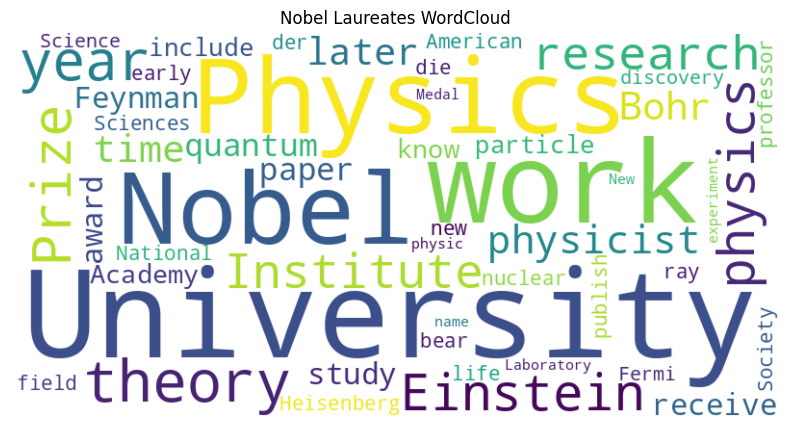

Word Dictionary:  {'University': 743, 'work': 728, 'Nobel': 571, 'Chemistry': 434, 'chemistry': 433, 'Prize': 393, 'research': 391, 'year': 340, 'study': 336, 'award': 297, 'Society': 290, 'structure': 245, 'life': 245, 'chemical': 244, 'receive': 235, 'Academy': 234, 'time': 233, 'Hahn': 233, 'Institute': 232, 'include': 224, 'later': 221, 'Sciences': 212, 'chemist': 198, 'Haber': 197, 'early': 188, 'publish': 183, 'American': 181, 'Science': 176, 'know': 171, 'Royal': 171, 'reaction': 170, 'Chemical': 167, 'professor': 166, 'National': 165, 'develop': 164, 'element': 162, 'german': 161, 'bear': 160, 'World': 160, 'scientific': 156, 'member': 155, 'new': 153, 'die': 151, 'name': 151, 'Medal': 150, 'theory': 149, 'method': 148, 'science': 140, 'Research': 137, 'molecule': 136}


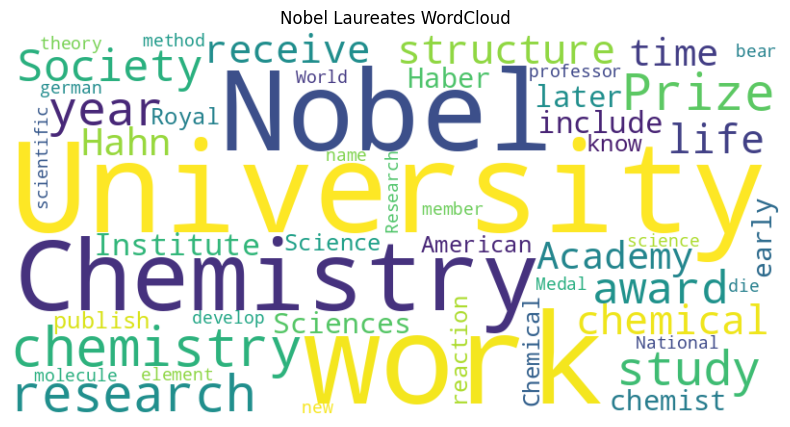

In [16]:


def plot_wordcloud(text):
    # Generate the 50 most frequent words in the laureates' biographies
    word_freq = Counter(text.split()).most_common(50)
    word_dict = dict(word_freq)
    print("Word Dictionary: ", word_dict)
    # Create a WordCloud object for the laureates 50 most frequent words
    wordcloud = WordCloud(width=800, height=400, background_color ='white').fit_words(word_dict)
    # Plot the WordCloud for the laureates
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nobel Laureates WordCloud')
    plt.show()

# Combine physics laureate biographies into a single string
physics_text = ' '.join(physics_and_chemistry_nobel_laureate[physics_and_chemistry_nobel_laureate['category'] == 'Physics']['clean_biography'])

# Combine chemistry laureate biographies into a single string
chemistry_text = ' '.join(physics_and_chemistry_nobel_laureate[physics_and_chemistry_nobel_laureate['category'] == 'Chemistry']['clean_biography'])

# Plot the WordCloud for the physics laureates
plot_wordcloud(physics_text)

# Plot the WordCloud for the chemistry laureates
plot_wordcloud(chemistry_text)


## Graph Cloud

In [52]:
import os

categories = ["physics_nobel_laureate", "chemistry_nobel_laureate"]


In [81]:
import json

def concat_json_graphs(folder_path):
    graph_list = []
    json_files = [json for json in os.listdir(folder_path) if json.endswith(".json")]
    json_files_path = [os.path.join(folder_path, json) for json in json_files]
    for json_file in json_files_path:
        with open(json_file, "r") as f:
            json_graph = json.load(f)
            graph_list.append(json_graph)
    return graph_list

In [82]:
chemistry_graphs = concat_json_graphs("chemistry_nobel_laureate")
physics_graphs = concat_json_graphs("physics_nobel_laureate")
